In [6]:
import sys
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
sys.path.append("../Modules/")
import helper

In [7]:
class XForce_Grapher():
    def __init__(self) -> None:
        self._data = None
        self._sources = None
        self._queries = None
        self._summary = None
        self._nlp_summary = None
        self._data_size = None
        self._sparse_matrix = None
        self._sparse_matrix_names = None
        self.load("../../data/complete_db.csv")
        return None

    def load(self, path: str) -> None:
        self.load_db(path)
        self.load_db_summary()
        return None

    def peek_data(self):
        return self._data.head()
    
    def get_data(self):
        return self._data

    def get_sources(self):
        return self._sources

    def get_queries(self):
        return self._queries
    
    def get_summary(self):
        return self._summary

    def peek_nlp_summary(self):
        if self._nlp_summary is not None:
            return self._nlp_summary.sort_values(by="abstract_word_count").reset_index().iloc[helper.np.r_[0:5, -5:0]]
        else:
            print("Please run .load_nlp_summary() first.")
            return None

    def get_nlp_summary(self):
        if self._nlp_summary is not None:
            return self._nlp_summary
        else:
            print("Please run .load_nlp_summary() first.")
            return None

    def set_data(self, path: str) -> None:
        self.load(path)
        return None

    def load_db(self, path: str) -> None:
        df = helper.pd.read_csv(path)
        sources = list(set(df["source"].values.tolist()))
        sources.append("ALL")
        queries = list(set(df["query"].values.tolist()))
        queries.append("ALL")

        self._data = df
        self._data_size = len(df)
        self._sources = sources
        self._queries = queries
        return None

    def graph_pub_freq(self, 
                       queries: list=["ALL"], 
                       sources: list=["ALL"],
                       country_mode: int=1) -> None:
        """
        # TODO Fix scopus date. Do not you run "ALL" for sources.
        # TODO Add country_mode

        Graphs the publishing frequency of papers in the database.

        queries -> list
            The given list of search queries (can be a 1-item list) that match database queries
            ALL: Considers all queries

        sources -> list
            The given list of search sources (can be a 1-item list) that match database sources
            ALL: Considers all sources

        country_mode -> int
            0: graphs the bars of the bar chart as normal bars
            1: graphs the bars of the bar chart as stacked bar charts corresponding to country of publishing institution

        Returns -> None
            Shows matplotlib graph of the published frequency
        
        Example
            grapher = XForce_Grapher()
            grapher.graph_pub_freq(["ALL"], ["ALL"], 1)
        """
        # Input Error Handling
        country_mode_options = {0,1}
        if country_mode not in country_mode_options:
            print(f"{country_mode} invalid, must be {country_mode_options}")
            return None

        for source in sources:
            if source not in self._sources:
                raise ValueError(f"{source} invalid, must be {self._sources}")
        
        for query in queries:
            if query not in self._queries:
                raise ValueError(f"{query} invalid, must be {self._queries}")

        # Load Data
        df = self._data.copy()
        
        # Filter Data
        title_sources, title_queries = ["ALL"], ["ALL"]
        if "ALL" not in sources:
            expression = helper.generate_boolean_conditions("source", sources)
            df = df[eval(expression)]
            title_sources = sources
        if "ALL" not in queries:
            expression = helper.generate_boolean_conditions("query", queries)
            df = df[eval(expression)]
            title_queries = queries
        
        # Data Setup
        dates_extract = df["published"].apply(lambda x: x.split('T')[0])
        dates = [helper.datetime(int(i.split("-")[0]), int(i.split("-")[1]), int(i.split("-")[2])) for i in dates_extract]
        
        # Graph
        helper.plt.title(f"Source: {title_sources}, Query: {title_queries}", fontsize=3)
        helper.plt.suptitle(f"Publish Frequency within {len(dates)} Most Recent Papers")
        helper.plt.xlabel("Publish Dates")
        helper.plt.ylabel("Frequency")
        helper.plt.grid("True")
        helper.plt.xticks(rotation=45)
        helper.plt.hist(dates, 25, alpha=.75)
        helper.plt.tight_layout()
        helper.plt.savefig(f"../images/pub_freq/pub_freq_{'_'.join(title_sources)}_{'_'.join(title_queries)}.png")
        helper.plt.show()

        # Return
        return None

    def load_db_summary(self) -> None:
        """
        Generates the report table of the count of paper entries by query and by source and stores it in class attribute.

        Returns -> None
            Stores the report dataframe into class attribute.

        Example
            grapher = XForce_Grapher()
            grapher.load_db_summary()
        """
        df = self._data.copy()
        sources = self._sources.copy()
        queries = self._queries.copy()
        l = [["source"], queries]
        data_header = [item for sublist in l for item in sublist]
        data_rows = []
        for source in sources:
            data_row = [source]
            if source == "ALL":
                filtered_by_source_df = df
            else:
                filtered_by_source_df = df[df["source"] == source]
            for query in queries:
                filtered_by_query_df = filtered_by_source_df[filtered_by_source_df["query"] == query]
                data_row.append(len(filtered_by_query_df))
            data_rows.append(data_row)
        report = helper.pd.DataFrame(data=data_rows, columns=data_header).iloc[:, :-1]
        self._summary = report
        return None
    
    def report_db_summary(self) -> None:
        """ 
        Prints a report table of the count of paper entries by query and by source.

        Returns -> None
            Both prints and returns the report dataframe.

        Example
            grapher = XForce_Grapher()
            grapher.report_db_summary()
        """
        print(self._summary)
        return None

    def graph_db_summary(self) -> None:
        """
        Graphs the report summary as a stacked barchart.

        Returns -> None
            Prints out matplotlib graph of the report summary
        
        Example
            grapher = XForce_Grapher()
            grapher.graph_db_summary()
        """
        df = self._summary.copy()
        extract_counts = df.T.values.tolist()[1:-1] # -1 to remove the "ALL" from the category
        extract_queries = df.T.index.tolist()[1:-1]
        sources = df["source"]

        query_count_data = {}
        for i in range(len(extract_counts)):
            query_count_data[extract_queries[i]] = extract_counts[i]
        
        width = 0.5
        fig, ax = helper.plt.subplots()
        bottom = helper.np.zeros(3)

        for query, count in query_count_data.items():
            p = ax.bar(sources, count, width, label=query, bottom=bottom)
            bottom += count

        helper.plt.title(f"Distribution of {self._data_size} Articles")
        helper.plt.xlabel("Source")
        helper.plt.ylabel("Counts")
        helper.plt.grid("True")
        helper.plt.legend(loc='upper left', bbox_to_anchor=(1,1))
        helper.plt.tight_layout()
        helper.plt.savefig(f"../images/db_summ/db_summ.png")
        helper.plt.show()

        return None
    
    def helper_remove_stopwords(self, input):
        """
        # TODO fill in docstring
        """
        words = input.split(" ")
        filtered_words = [word for word in words if word not in helper.MASTER_STOP_WORDS]
        output = " ".join(filtered_words)
        return output
    
    def helper_lemmatizer(self, input):
        """
        # TODO fill in docstring
        """
        wordnet_lemmatizer = helper.WordNetLemmatizer()
        words = input.split(" ")
        lemma_words = [wordnet_lemmatizer.lemmatize(word) for word in words]
        output = " ".join(lemma_words)
        return output

    def load_nlp_summary(self) -> None:
        """
        Creates, pre-processes, and saves the NLP summary report in class variable, which is ready for analytics.

        Returns -> None
            Saves the NLP summary report.
        
        Example
            grapher = XForce_Grapher()
            grapher.load_nlp_summary()
        """
        # Filtering
        df = self._data.copy()
        df = df[["source", "query", "published", "url", "title", "abstract"]]
        
        # Cleaning & Feature Creation
        df.dropna(inplace=True)
        col_to_process = ["title", "abstract"]
        for col in col_to_process:
            df.loc[:, col] = df.loc[:, col].apply(lambda x: x.lower())
            df.loc[:, col] = df.loc[:, col].apply(lambda x: self.helper_remove_stopwords(x))
            df.loc[:, col] = df.loc[:, col].apply(lambda x: helper.re.sub('[%s]' % helper.re.escape(helper.string.punctuation), ' ' , x))
            df.loc[:, col] = df.loc[:, col].apply(lambda x: helper.re.sub(r'\d+', '', x))
            df.loc[:, col] = df.loc[:, col].apply(lambda x: helper.re.sub(' +', ' ', x))
            df.loc[:, col] = df.loc[:, col].apply(lambda x: self.helper_lemmatizer(x))
            df[f"{col}_char_count"] = df.loc[:, f"{col}"].map(lambda x: len(x))
            df[f"{col}_word_count"] = df.loc[:, f"{col}"].map(lambda x: len(x.split(" ")))

        # Saving
        self._nlp_summary = df
        
        # Return
        return None
    
    def graph_text_freq(self, 
                         queries: list=["ALL"], 
                         sources: list=["ALL"], 
                         text_mode: str="word", 
                         type_mode: str="abstract") -> None:
        """
        Graphs the text frequency (eg. character/word count of title/abstract) of indicated papers

        queries -> list
            The given list of search queries (can be a 1-item list) that match database queries
            ALL: Considers all queries

        sources -> list
            The given list of search sources (can be a 1-item list) that match database sources
            ALL: Considers all sources

        text_mode -> str
            Given type mode to filter on
            "char": Graphs via character count
            "word": Graphs via word count

        type_mode -> str
            Given type mode to filter on
            "title": Graphs on title
            "abstract": Graphs on abstract

        Returns -> None
            Shows matplotlib graph of the text counts
        
        Example
            grapher = XForce_Grapher()
            grapher.graph_text_freq(queries=["radiation", "plasmonics"], source=["arxiv"], text_mode="word", type_mode="abstract")
        """
        # Input Error Handling
        for source in sources:
            if source not in self._sources:
                raise ValueError(f"{source} invalid, must be {self._sources}")
        
        for query in queries:
            if query not in self._queries:
                raise ValueError(f"{query} invalid, must be {self._queries}")

        text_mode_options = {"char", "word"}
        if text_mode not in text_mode_options:
            raise ValueError(f"{text_mode} invalid; must be {text_mode_options}")

        type_mode_options = {"title", "abstract"}
        if type_mode not in type_mode_options:
            raise ValueError(f"{type_mode} invalid; must be {type_mode_options}")

        # Load Data
        df = self._nlp_summary.copy()
        
        # Filter Data
        title_sources, title_queries = ["ALL"], ["ALL"]
        if "ALL" not in sources:
            expression = helper.generate_boolean_conditions("source", sources)
            df = df[eval(expression)]
            title_sources = sources
        if "ALL" not in queries:
            expression = helper.generate_boolean_conditions("query", queries)
            df = df[eval(expression)]
            title_queries = queries
        else:
            queries = self._queries[:-1]

        # Data Setup
        expression = f"{type_mode}_{text_mode}_count"
        graph_data = []
        for query in queries:
            graph_data.append(df[df["query"] == query][expression])

        # Graphing
        helper.plt.title(f"Source: {title_sources}, Query: {title_queries}")
        helper.plt.suptitle(f"Summary Statistics of {type_mode.title()} {text_mode.title()} Count by Specified Papers")
        helper.plt.xlabel("Query")
        helper.plt.ylabel("Count")
        helper.plt.grid("True")
        helper.plt.xticks(rotation=45)
        helper.plt.boxplot(graph_data, positions=helper.np.array(range(len(graph_data)))*2.0, sym='', widths=1.5)
        helper.plt.xticks(range(0, len(queries)*2, 2), queries, rotation=45)
        helper.plt.tight_layout()
        helper.plt.savefig(f"../images/text_freq/text_freq_{'_'.join(title_sources)}_{'_'.join(title_queries)}.png")
        helper.plt.show()

        return None

    def graph_keyword_freq(self, 
                           queries: list=["ALL"], 
                           sources: list=["ALL"], 
                           type_mode: str="abstract", 
                           k: int=15, 
                           n_gram: int=2) -> None:
        """
        Graphs the keyword frequency of the specified papers. 

        queries -> list
            The given list of search queries (can be a 1-item list) that match database queries
            ALL: Considers all queries

        sources -> list
            The given list of search sources (can be a 1-item list) that match database sources
            ALL: Considers all sources

        type_mode -> str
            Given type mode to filter on
            "title": Graphs on title
            "abstract": Graphs on abstract

        k -> int
            The number of top n-grams to be graphed

        n_gram -> int
            The n-grams to graph on

        stop_words -> set
            The set of stop_words to use in the CountVectorizer()

        Returns -> None
            Shows matplotlib graph of the text counts
        
        Example
            grapher = XForce_Grapher()
            grapher.graph_text_count(queries=["radiation", "plasmonics"], source="arxiv", type_mode="abstract", k=15, n_grams=1)
        """
        # Input Error Handling
        for source in sources:
            if source not in self._sources:
                raise ValueError(f"{source} invalid, must be {self._sources}")
        
        for query in queries:
            if query not in self._queries:
                raise ValueError(f"{query} invalid, must be {self._queries}")

        type_mode_options = {"title", "abstract"}
        if type_mode not in type_mode_options:
            raise ValueError(f"{type_mode} invalid; must be {type_mode_options}")

        # Load Data
        if self._nlp_summary is None:
            print("Running .load_nlp_summary() first, ETA ~1 minute.")
            self.load_nlp_summary()
        df = self._nlp_summary.copy()
        print("Running .graph_keyword_freq(), ETA ~1.5 minutes.")

        # Filter Data
        title_sources, title_queries = ["ALL"], ["ALL"]
        if "ALL" not in sources:
            expression = helper.generate_boolean_conditions("source", sources)
            df = df[eval(expression)]
            title_sources = sources
        if "ALL" not in queries:
            expression = helper.generate_boolean_conditions("query", queries)
            df = df[eval(expression)]
            title_queries = queries
        else:
            queries = self._queries[:-1]
        X = df.loc[:, type_mode]
        
        # NLP Cleaning
        cvec = helper.CountVectorizer(ngram_range=(n_gram, n_gram))
        sparse = cvec.fit_transform(X)
        self._sparse_matrix = sparse
        names = cvec.get_feature_names_out()
        self._sparse_matrix_names = names
        ngram_counts = sparse.sum(axis=0).A1

        # Data Setup
        df = helper.pd.DataFrame(data=[ngram_counts], index=["counts"], columns=names)
        df = df.sort_values(by=df.index[0], axis=1, ascending=False)

        # Graphing
        helper.plt.title(f"Source: {title_sources}, Query: {title_queries}")
        helper.plt.suptitle(f"Top {k} Most Common {n_gram}-Grams in Papers from Given Queries")
        helper.plt.xlabel("Count")
        helper.plt.xticks(rotation=90)
        helper.plt.ylabel("Tokens")
        helper.plt.grid(True)
        helper.plt.barh(df.columns[:k][::-1], df.values[0][:k][::-1], alpha=0.5)

        # Saving
        helper.plt.tight_layout()
        helper.plt.savefig(f"../../images/keyword_freq/keyword_freq_{'_'.join(title_sources)}_{'_'.join(title_queries)}.png")
        helper.plt.show()

        return None

    def graph_network_cooccurence():
        # TODO
        return
    
    def graph_bubble_cloud() -> None:
        return

Running .graph_keyword_freq(), ETA ~1.5 minutes.


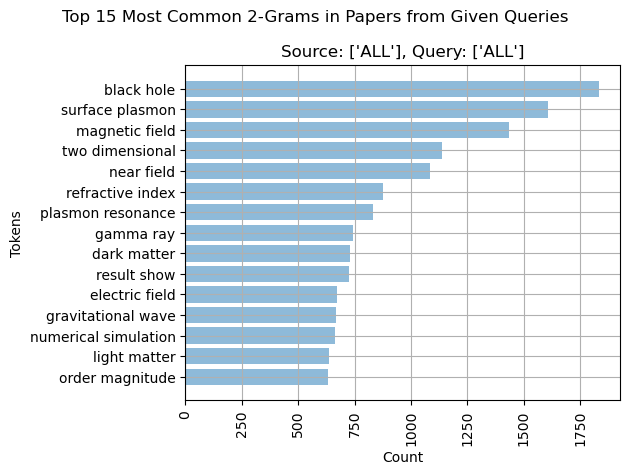

In [8]:
test = XForce_Grapher()
test.load_nlp_summary()
test.graph_keyword_freq()
df = test._sparse_matrix

In [11]:
df

<18163x1026001 sparse matrix of type '<class 'numpy.int64'>'
	with 1839380 stored elements in Compressed Sparse Row format>

In [12]:
names = test._sparse_matrix_names
names

array(['aa aa', 'aa ab', 'aa absorption', ..., '⁰c µl', '⁰riu comparing',
       '⁰riu obtained'], dtype=object)

In [19]:
u = 100
full_rows, full_cols = df.nonzero()
r = full_rows[:u]
c = full_cols[:u]
pairs = []
words = []
for i, j in zip(r, c):
    if i != j:
        pairs.append((names[i],names[j]))
        words.append(names[j])
text_data = " ".join(words)

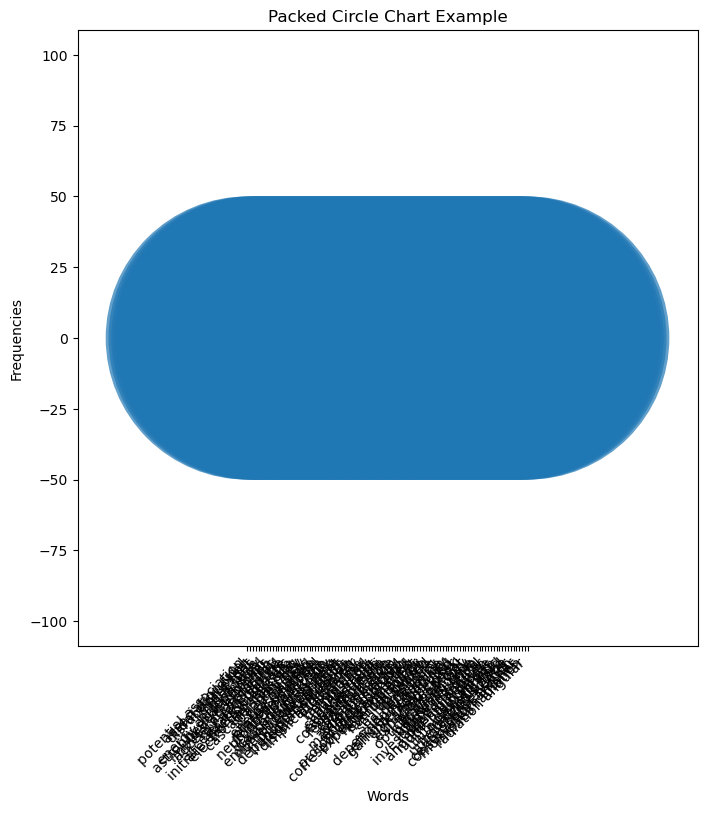

In [25]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

word_frequencies = Counter(words)

# Extract data for the packed circle chart
words = list(word_frequencies.keys())
frequencies = list(word_frequencies.values())

# Create the packed circle chart
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Calculate the area of each circle based on frequency (area = pi * r^2)
circle_sizes = [np.sqrt(freq) * 50 for freq in frequencies]  # Scale the size for better visibility

# Plot the circles
for i in range(len(words)):
    plt.gca().add_patch(plt.Circle((i, 0), circle_sizes[i], alpha=0.7))

# Customize the plot
plt.axis('equal')
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.title('Packed Circle Chart Example')

# Save the packed circle chart as a PNG image
plt.savefig('packed_circle_chart.png', dpi=300)  # 'packed_circle_chart.png' is the output filename
plt.show()

ValueError: ['red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black'] is not a valid value for color

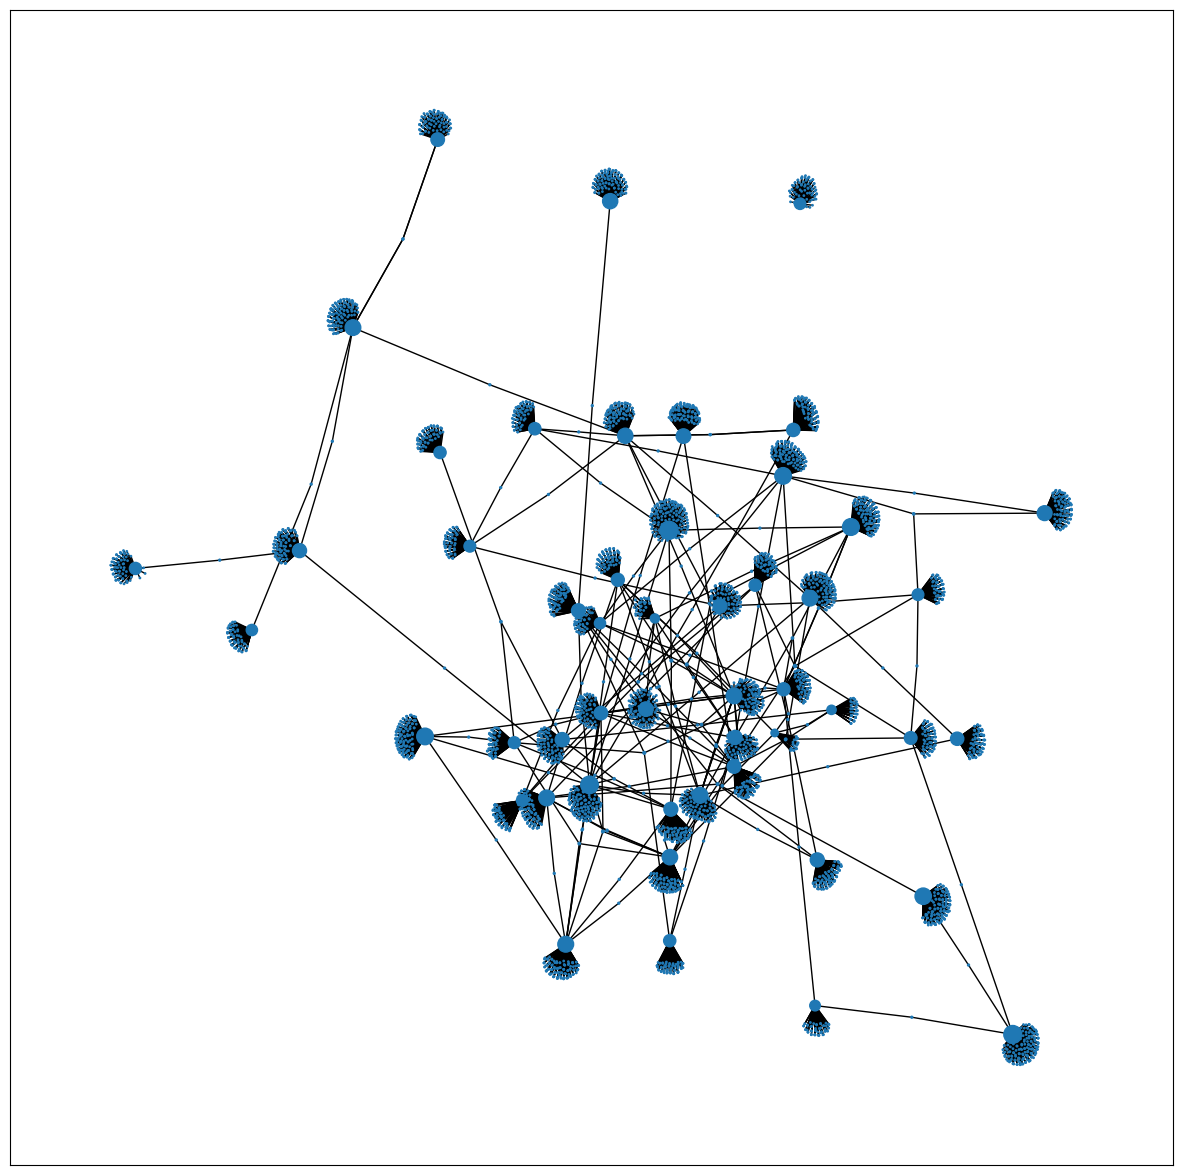

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from(pairs)
d = dict(G.degree)

show_labels = {node: True if degree >= 75 else False for node, degree in d.items()}
plt.figure(figsize=(15,15))
nx.draw_networkx(G, nodelist=d.keys(), node_size=[v for v in d.values()], with_labels=False)
nx.draw_networkx_labels(G, pos=nx.spring_layout(G), labels=node_labels, font_color=label_colors)
plt.show()

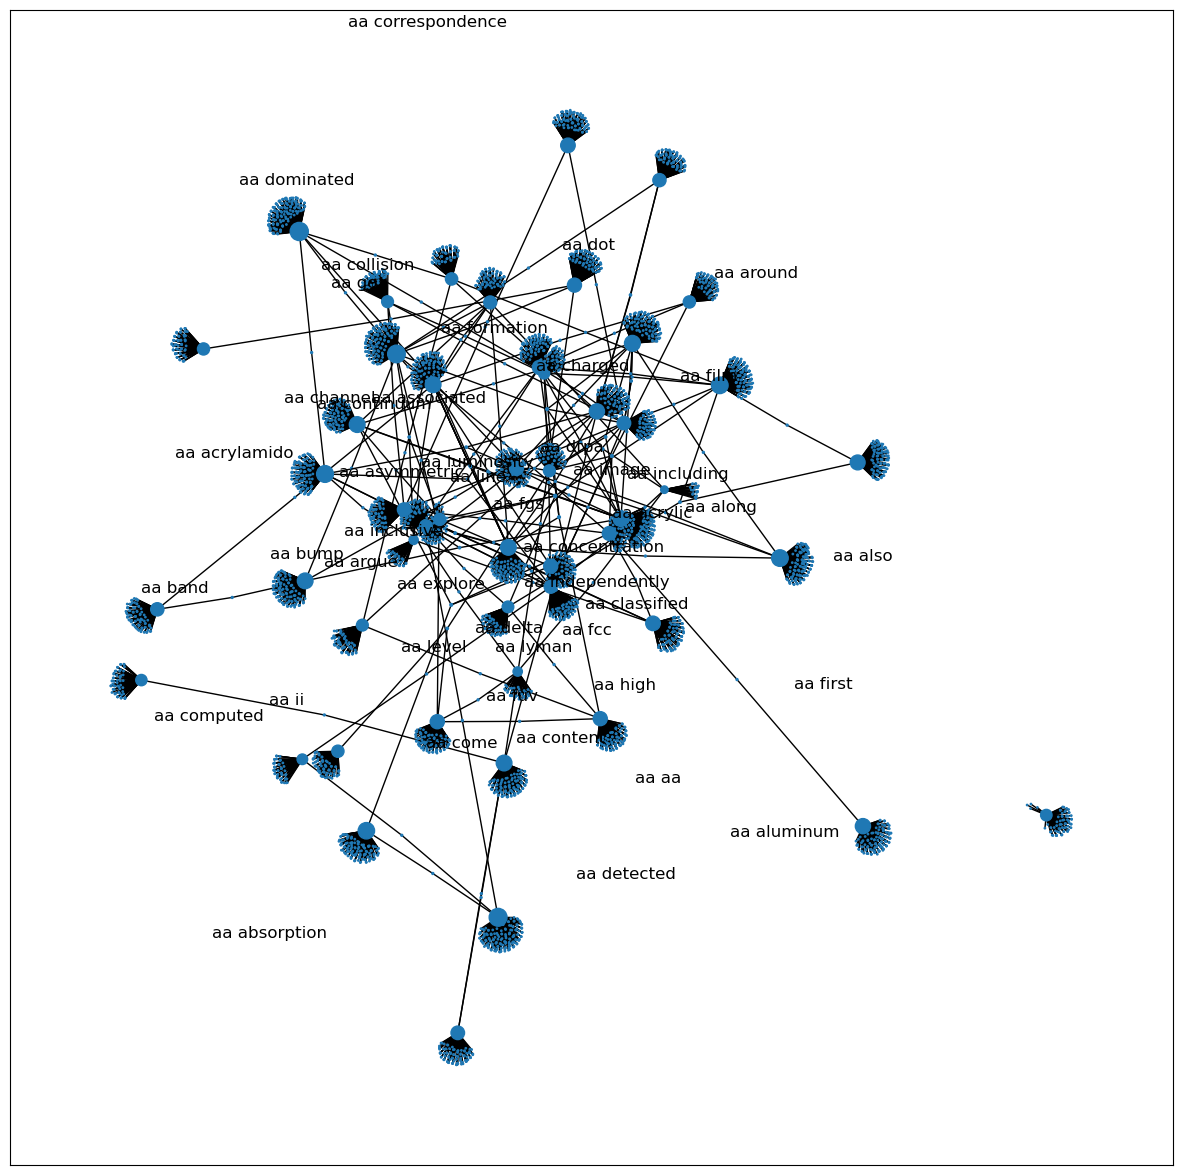

In [ ]:
G = nx.Graph()
G.add_edges_from(pairs)
d = dict(G.degree)

show_labels = {node: True if degree >= 50 else False for node, degree in d.items()}
plt.figure(figsize=(15, 15))
nx.draw_networkx(G, nodelist=d.keys(), node_size=[v for v in d.values()], with_labels=False)
nx.draw_networkx_labels(G, pos=nx.spring_layout(G), labels={node: node if show_labels[node] else "" for node in G.nodes()})

plt.show()

In [ ]:
u = helper.pd.get_dummies(helper.pd.DataFrame(lst), prefix='', prefix_sep='').sum(level=0, axis=1)
v = u.T.dot(u)
v.values[helper.np.tril(helper.np.ones(v.shape)).astype(bool)] = 0
a = v.stack()
a = a[a >= 1].rename_axis(('source', 'target')).reset_index(name='weight')
a

,source,target,weight
0,a,b,1
1,a,d,1
2,b,c,1
3,b,d,1
4,b,e,12
5,b,f,1
6,b,g,1
7,b,h,1
8,b,i,1
9,b,j,1


In [ ]:
import networkx as nx
# Create a graph from the DataFrame using from_pandas_edgelist
G = nx.from_pandas_edgelist(df, 'source', 'target')

# Compute the weights as the number of occurrences of each edge
weights = df.groupby(['source', 'target']).size().reset_index(name='weight')

# Calculate the node sizes based on the weights
node_sizes = weights.groupby('source')['weight'].sum().tolist()

# Draw the graph with node size based on weight
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_size=node_sizes)

# Show the graph
helper.plt.show()

KeyError: 'target'

ValueError: s must be a scalar, or float array-like with the same size as x and y

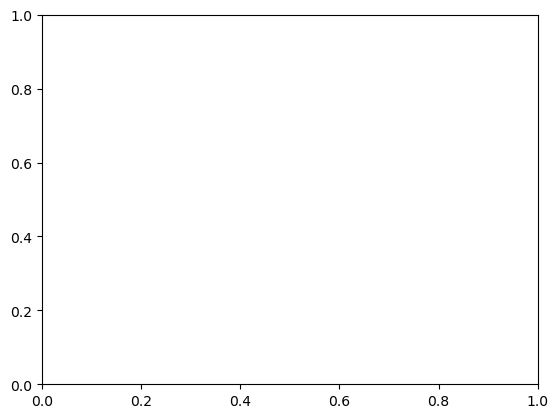

In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(a, 'source', 'target', edge_attr='weight', create_using=nx.DiGraph())

weights = [G.edges[edge]['weight'] for edge in G.edges]

# Set the node size based on the weights
node_sizes = [weight * 100 for weight in weights]

# Draw the graph with node size based on weight
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_size=node_sizes)

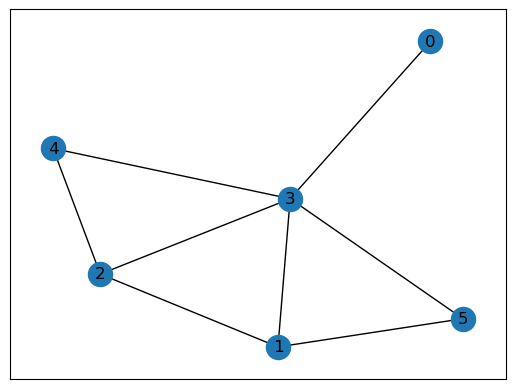

In [ ]:
import networkx as nx
 
# Create a networkx graph object
my_graph = nx.Graph() 
 
# Add edges to to the graph object
# Each tuple represents an edge between two nodes
my_graph.add_edges_from([
                        (1,2), 
                        (1,3), 
                        (3,4), 
                        (1,5), 
                        (3,5),
                        (4,2),
                        (2,3),
                        (3,0)])
 
# Draw the resulting graph
pos = nx.spring_layout(my_graph)
nx.draw_networkx(my_graph, pos, with_labels=True)

# DEV

NameError: name 'big_counts' is not defined

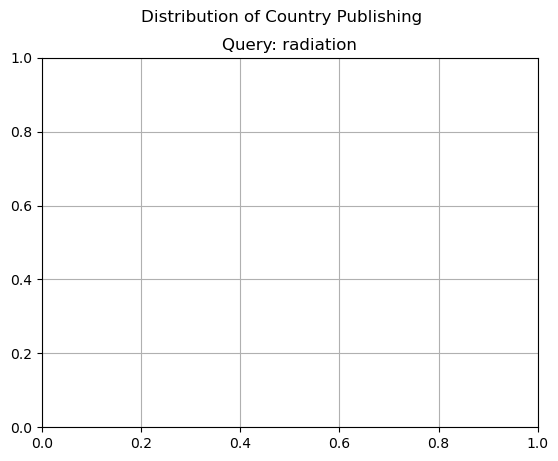

In [ ]:
countries = ["US", "UK", "China", "Germany", "Switzerland", "Other"]
helper.plt.suptitle(f"Distribution of Country Publishing")
helper.plt.title(f"Query: {df['query'][0]}")
helper.plt.grid("True")
values = sorted(big_counts[0], reverse=True)
helper.plt.pie(values, labels=countries)
helper.plt.legend(loc='upper left', bbox_to_anchor=(1,1))
helper.plt.show()